# Eksplorasi Library Decision Tree pada Jupyter Notebook
Anggota (K03):
- Benidictus Galih Mahar Putra  - 13519159
- Alvin Wilta                   - 13519163

## Load Datasets

Library yang digunakan pada notebook ini adalah:
- pandas (operasi sederhana pada dataset)
- sklearn (modul machine learning)
- graphviz (visualisasi tree id3)
- id3 (melakukan algoritma id3)
- matplotlib (visualisasi tree decision tree classification)
- six, sys (menangani konflik dari library id3)

In [70]:
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz


In [71]:
cancer = datasets.load_breast_cancer(as_frame=True)
dttennis = pd.read_csv("../data/play_tennis.csv")

In [72]:
dtcancer = cancer.data.copy()
dtcancer['res'] = cancer.target

In [73]:
# Inisialisasi datagrame kosong untuk rekap semua nilai skor
recap = pd.DataFrame(columns=['Pembelajaran','Dataset','Tipe','Nilai'])

In [74]:
def addToRecap(pemb, cancer_acc, cancer_f1, tennis_acc, tennis_f1):
    if len(recap.index) != 0:
        if (recap['Pembelajaran'].loc[len(recap.index)-1] == pemb):
            recap.drop(recap.tail(4).index, inplace=True)
    c = 'Cancer'
    t = 'Tennis'
    acc = 'Accuracy Score'
    f1 = 'F1 Score'
    i = len(recap)
    recap.loc[i] = [pemb, c, acc, cancer_acc]
    recap.loc[i+1] = [pemb, c, f1, cancer_f1]
    recap.loc[i+2] = [pemb, t, acc, tennis_acc]
    recap.loc[i+3] = [pemb, t, f1, tennis_f1]


In [75]:
def simpleDescribe(df: datasets):
    print('Jumlah kolom: ' + str(len(df.columns)))
    print('Jumlah baris: ' + str(len(df)))
    print()
    print('Kolom pada tabel:')
    print(df.columns.tolist())

def printScore(acc, f1):
    print('Accuracy   :', acc)
    print('F1 Score   :', f1)

def printSummary(pemb, cacc, cf1, tacc, tf1):
    addToRecap(pemb, cacc, cf1, tacc, tf1)
    print('===============================')
    print('Cancer Dataset:')
    print('Accuracy   :', cacc)
    print('F1 Score   :', cf1)
    print('===============================')
    print('Tennis Dataset')
    print('Accuracy   :', tacc)
    print('F1 Score   :', tf1)
    print('===============================')


### Data Breast Cancer

Sampel data kanker payudara yang disediakan oleh data internal sklearn:

In [76]:
dtcancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,res
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [77]:
simpleDescribe(dtcancer)

Jumlah kolom: 31
Jumlah baris: 569

Kolom pada tabel:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'res']


### Data Tennis
Sampel data tennis yang didapatkan dari file eksternal pada folder data: 

In [78]:
dttennis.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [79]:
simpleDescribe(dttennis)

Jumlah kolom: 6
Jumlah baris: 14

Kolom pada tabel:
['day', 'outlook', 'temp', 'humidity', 'wind', 'play']


Terdapat beberapa hal penting yang bisa dilihat disini, yaitu:
1. Kolom 'day' pada dataset merupakan data hari ke-sekian dan merupakan urutan hari dalam minggu. Untuk bisa mengetahui pola atau pengaruh 'urutan hari' dari sebuah tabel terhadap play adalah dengan melakukan operasi modulo 7 untuk melihat pengaruh hari (senin, selasa, dll) terhadap atribut play. Akan tetapi karena data yang dipakai sangat kecil (14 record) maka kolom ini dapat di-drop karena tidak terlalu berpengaruh.
2. Data pada dataset tersebut masih berupa string dan perlu untuk di-encode sesuai dengan kategorinya

In [80]:
dttennis.drop(columns=['day'], inplace=True)
dttennis.head()

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


#### Encode Play Tennis Column

In [81]:
le = LabelEncoder()
dttennis_old = dttennis.copy()
for col in dttennis_old[1:]:
    dttennis[col] = le.fit_transform(dttennis_old[col])
dttennis.head()

,outlook,temp,humidity,wind,play
0,2,1,0,1,0
1,2,1,0,0,0
2,0,1,0,1,1
3,1,2,0,1,1
4,1,0,1,1,1


## Split Dataset

### Split into test and train

Memisahkan dataset menjadi 2 bagian, test dan train. Pembagian dilakukan secara random dengan 80% data train dan 20% data test.

In [82]:
# Dataset cancer
ctrain, ctest = model_selection.train_test_split(dtcancer, test_size=0.2, train_size=0.8, random_state=1)


# Dataset tennis
tntrain, tntest = model_selection.train_test_split(dttennis, test_size=0.2, train_size=0.8, random_state=1)

Kemudian untuk memisahkan atribut yang akan digunakan sebagai parameter dan atribut prediksi, dataset awal akan dibagi menjadi 4 bagian:
- **x train:** feature yang akan digunakan untuk train model
- **y train:** ground truth (hasil asli)
- **x test:** feature yang digunakan untuk diuji oleh model
- **y test:** data yang digunakan untuk memvalidasi hasil prediksi

### Dataset Cancer

In [83]:
y = dtcancer['res']
x = dtcancer.drop('res', axis=1)

x_ctrain, x_ctest, y_ctrain, y_ctest = model_selection.train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=1)

### Dataset Tennis

In [84]:
y = dttennis['play']
x = dttennis.drop('play', axis=1)

x_tntrain, x_tntest, y_tntrain, y_tntest = model_selection.train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=1)

***

# Pembelajaran Mesin

Pada bagian ini akan ada 2 hal yang dibahas, yaitu akurasi model dan nilai f1 dari model. Berikut adalah definisi dari masing-masing skor:

Akurasi model:
> Perbandingan antara jumlah data yang benar diprediksi dengan total jumlah data secara keseluruhan. Akurasi memiliki nilai maksimal 1 dan nilai minimal 0. 

Nilai F1:
> Sebuah pengukuran akurasi model terhadap dataset dan biasanya digunakan dalam klasifikasi biner. Nilai F1 juga merupakan sebuah cara untuk menggabungkan *precision* dan *recall* dari sebuah model. Recall dan precision akan berbanding lurus dengan nilai F1.

## Decision Tree Classifier

**Decision Tree Classifier** adalah sebuah metode supervised learning yang digunakan untuk memberikan model yang akan membagi data bergantung dari parameter tertentu.

Tahap pembuatan DTC adalah:
1. Pilih atribut terbaik menggunakan ASM (Attribute Selection Measures)
2. Buat atribut tersebut menjadi decision node dan pecah dataset menjadi lebih kecil
3. Ulangi secara rekursif hingga kondisi berikut terpenuhi:
    - semua atribut sudah habis
    - tidak ada instansi lain lagi
    - semua tuple terdapat dalam nilai atribut yang sama

Banyak metode ASM yang bisa digunakan, tetapi ASM yang akan dipakai disini adalah *Entropy*.

### DTC - Breast Cancer Dataset

Terdapat 30 parameter yang digunakan antara lain:
- mean radius
- mean texture 
- mean perimeter 
- mean area 
- mean smoothness 
- mean compactness 
- mean concavity 
- mean concave points 
- mean symmetry 
- mean fractal dimension 
- radius error 
- texture error 
- perimeter error 
- area error 
- smoothness error 
- compactness error 
- concavity error 
- concave points error 
- symmetry error 
- fractal dimension error 
- worst radius 
- worst texture 
- worst perimeter 
- worst area 
- worst smoothness 
- worst compactness 
- worst concavity 
- worst concave points 
- worst symmetry 
- worst fractal dimension

Kemudian dilakukan prediksi dengan criterion berupa entropy pada kode di bawah ini dan didapatkan akurasi beserta F1 dari hasil training model untuk memprediksi kanker.

In [85]:
clf_c = DecisionTreeClassifier(criterion='entropy')
clf_c = clf_c.fit(x_ctrain,y_ctrain)
y_cpred = clf_c.predict(x_ctest)
c_dtc_acc = accuracy_score(y_ctest,y_cpred)
c_dtc_f1 = f1_score(y_ctest,y_cpred)
printScore(c_dtc_acc, c_dtc_f1)

Accuracy   : 0.9385964912280702
F1 Score   : 0.953020134228188


Berikut di bawah ini adalah ilustrasi decision tree yang dihasilkan dari pembelajaran mesin Decision Tree Classifier menggunakan library matplotlib. warna biru pada leaf node menandakan **benign**, sedangkan warna orange pada leaf node menandakan **malignant**

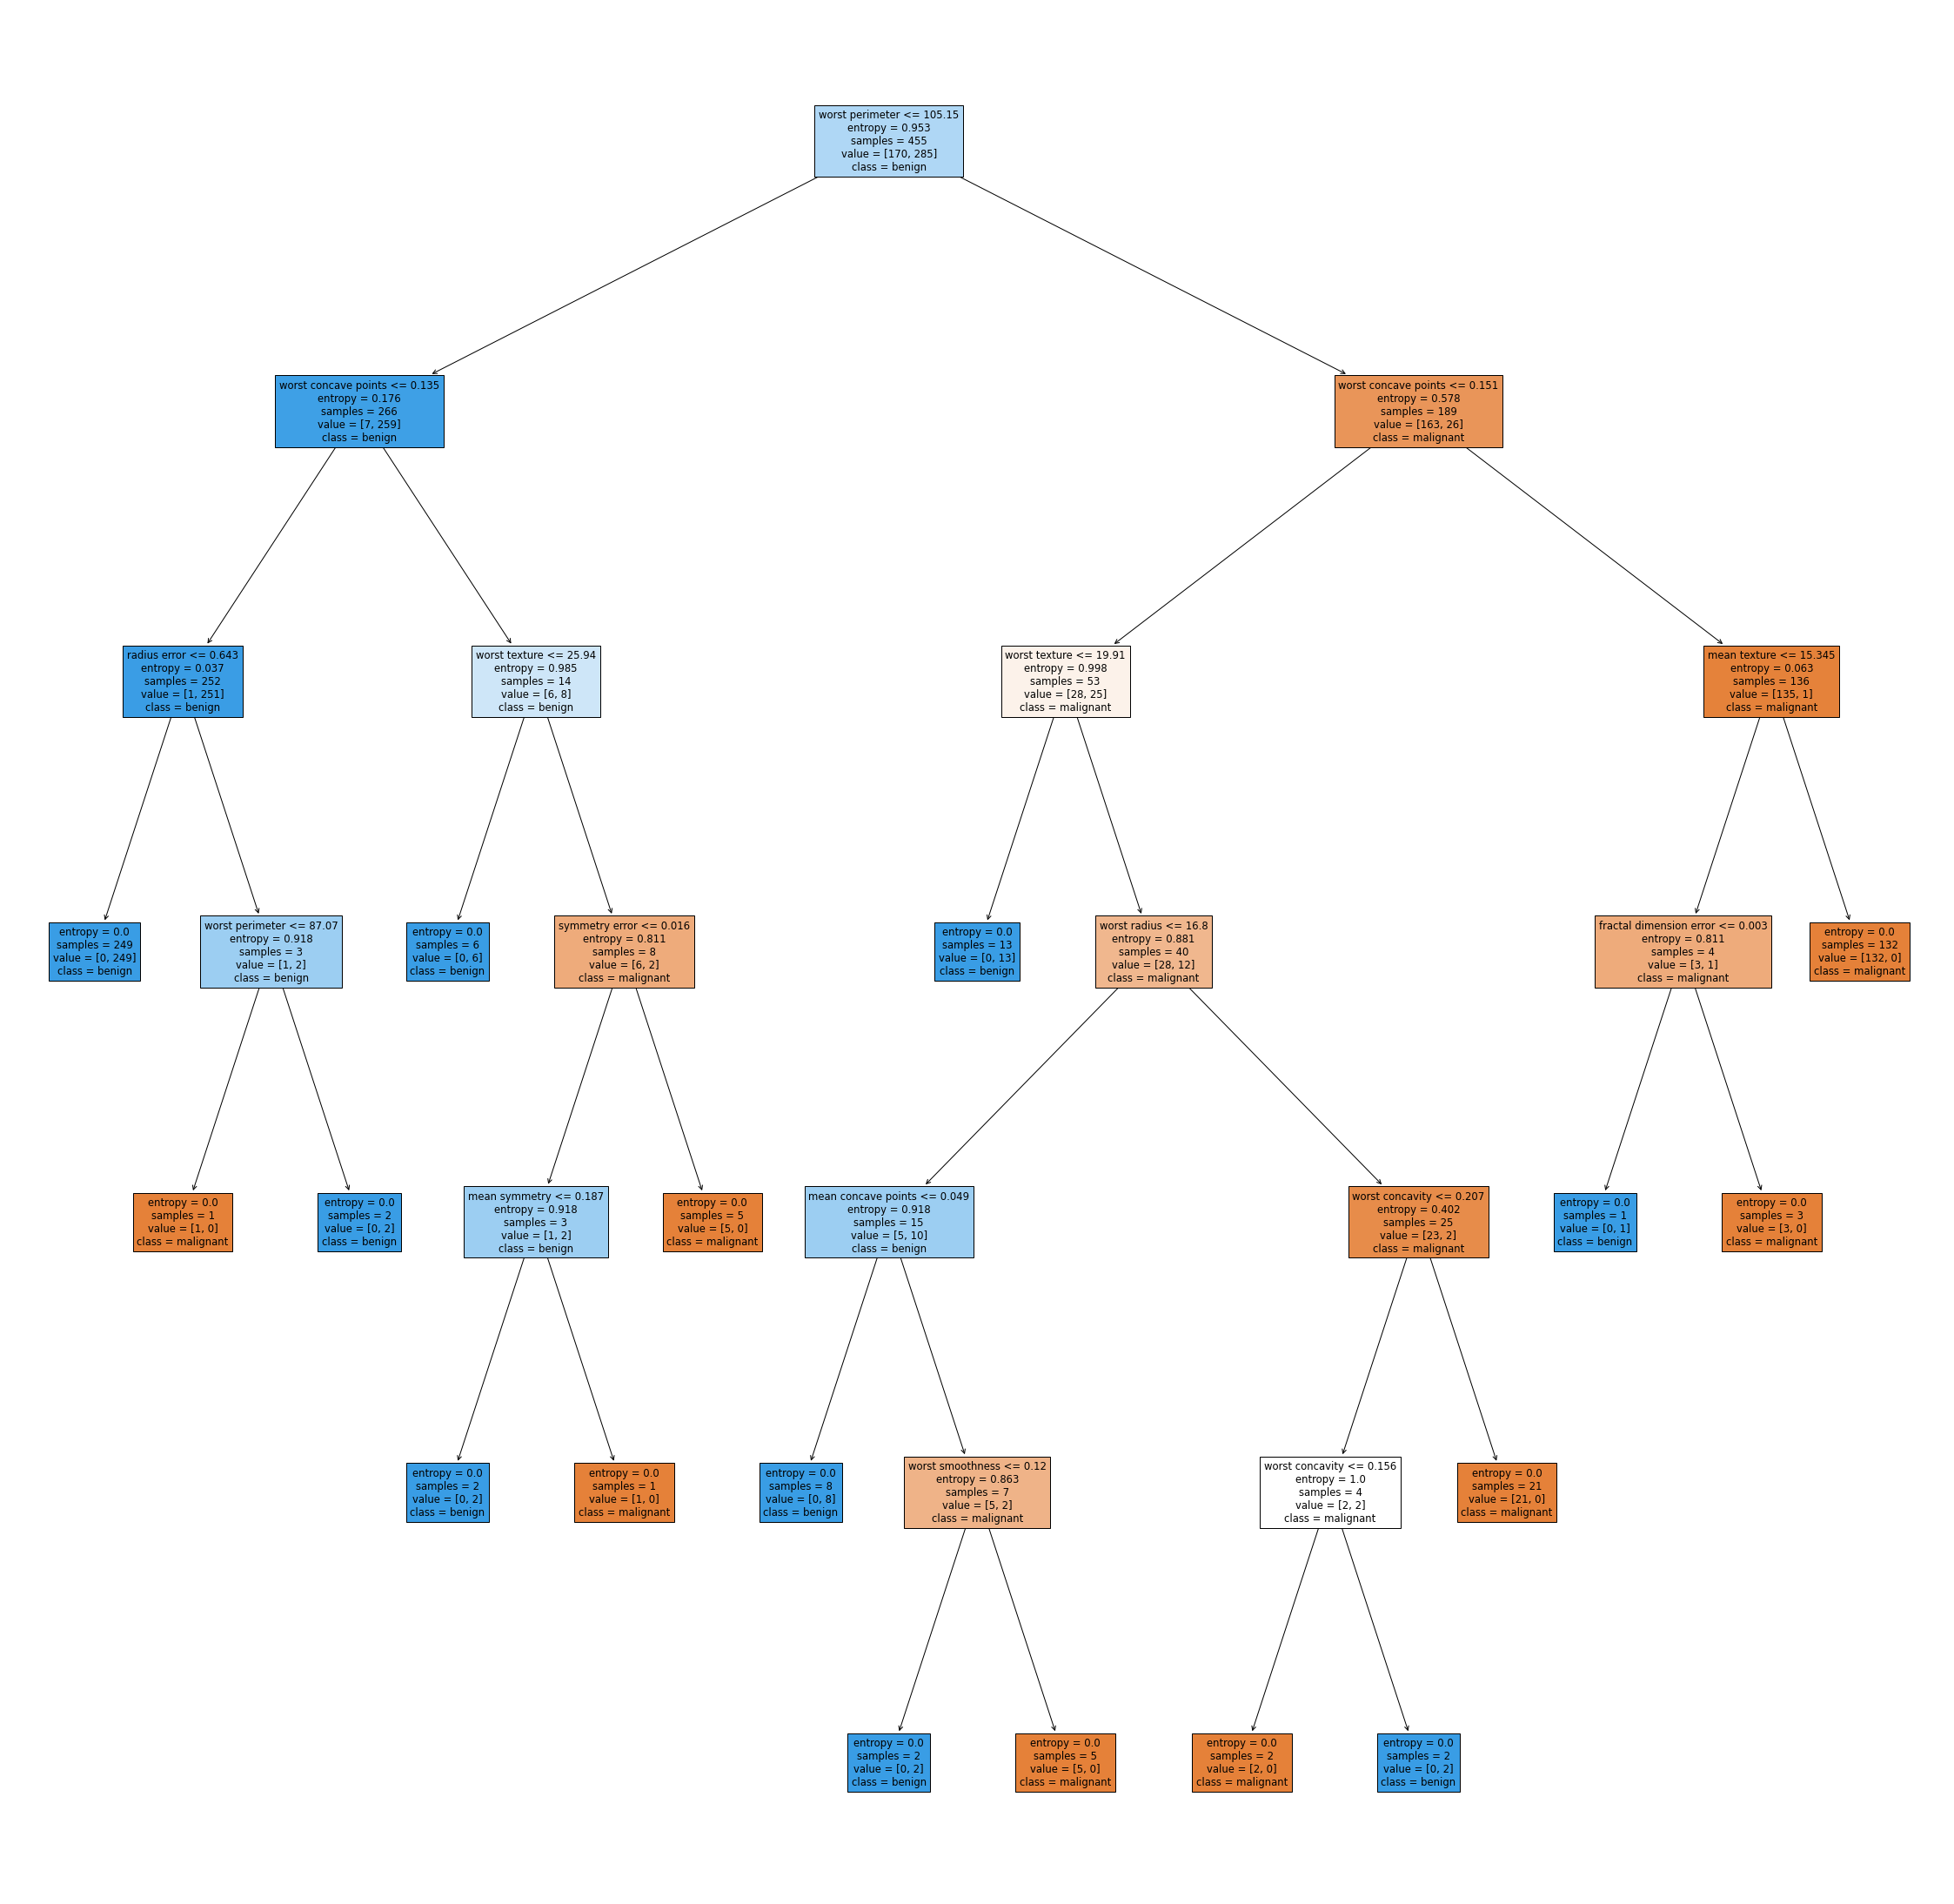

In [86]:
# Export text (textual)
# model = tree.export_text(clf_c)
# print(model)
fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf_c,feature_names=cancer.feature_names, class_names=cancer.target_names, filled=True)

Jalankan kode di bawah ini untuk menyimpan gambar figure:

In [87]:
fig.savefig("../img/cancer_dtc.png")

### DTC - Tennis Dataset

Terdapat 4 parameter yang digunakan, antara lain:
- outlook 
- temp 
- humidity 
- wind 

In [88]:
clf_t = DecisionTreeClassifier(criterion='entropy')
clf_t = clf_t.fit(x_tntrain, y_tntrain)
y_tnpred = clf_t.predict(x_tntest)
t_dtc_acc = accuracy_score(y_tntest,y_tnpred)
t_dtc_f1 = f1_score(y_tntest,y_tnpred)
printScore(t_dtc_acc, t_dtc_f1)

Accuracy   : 0.6666666666666666
F1 Score   : 0.6666666666666666


Berikut di bawah ini adalah ilustrasi decision tree yang dihasilkan dari pembelajaran mesin Decision Tree Classifier menggunakan library matplotlib pada dateset tennis. warna biru pada leaf node menandakan **No**, sedangkan warna orange pada leaf node menandakan **Yes**

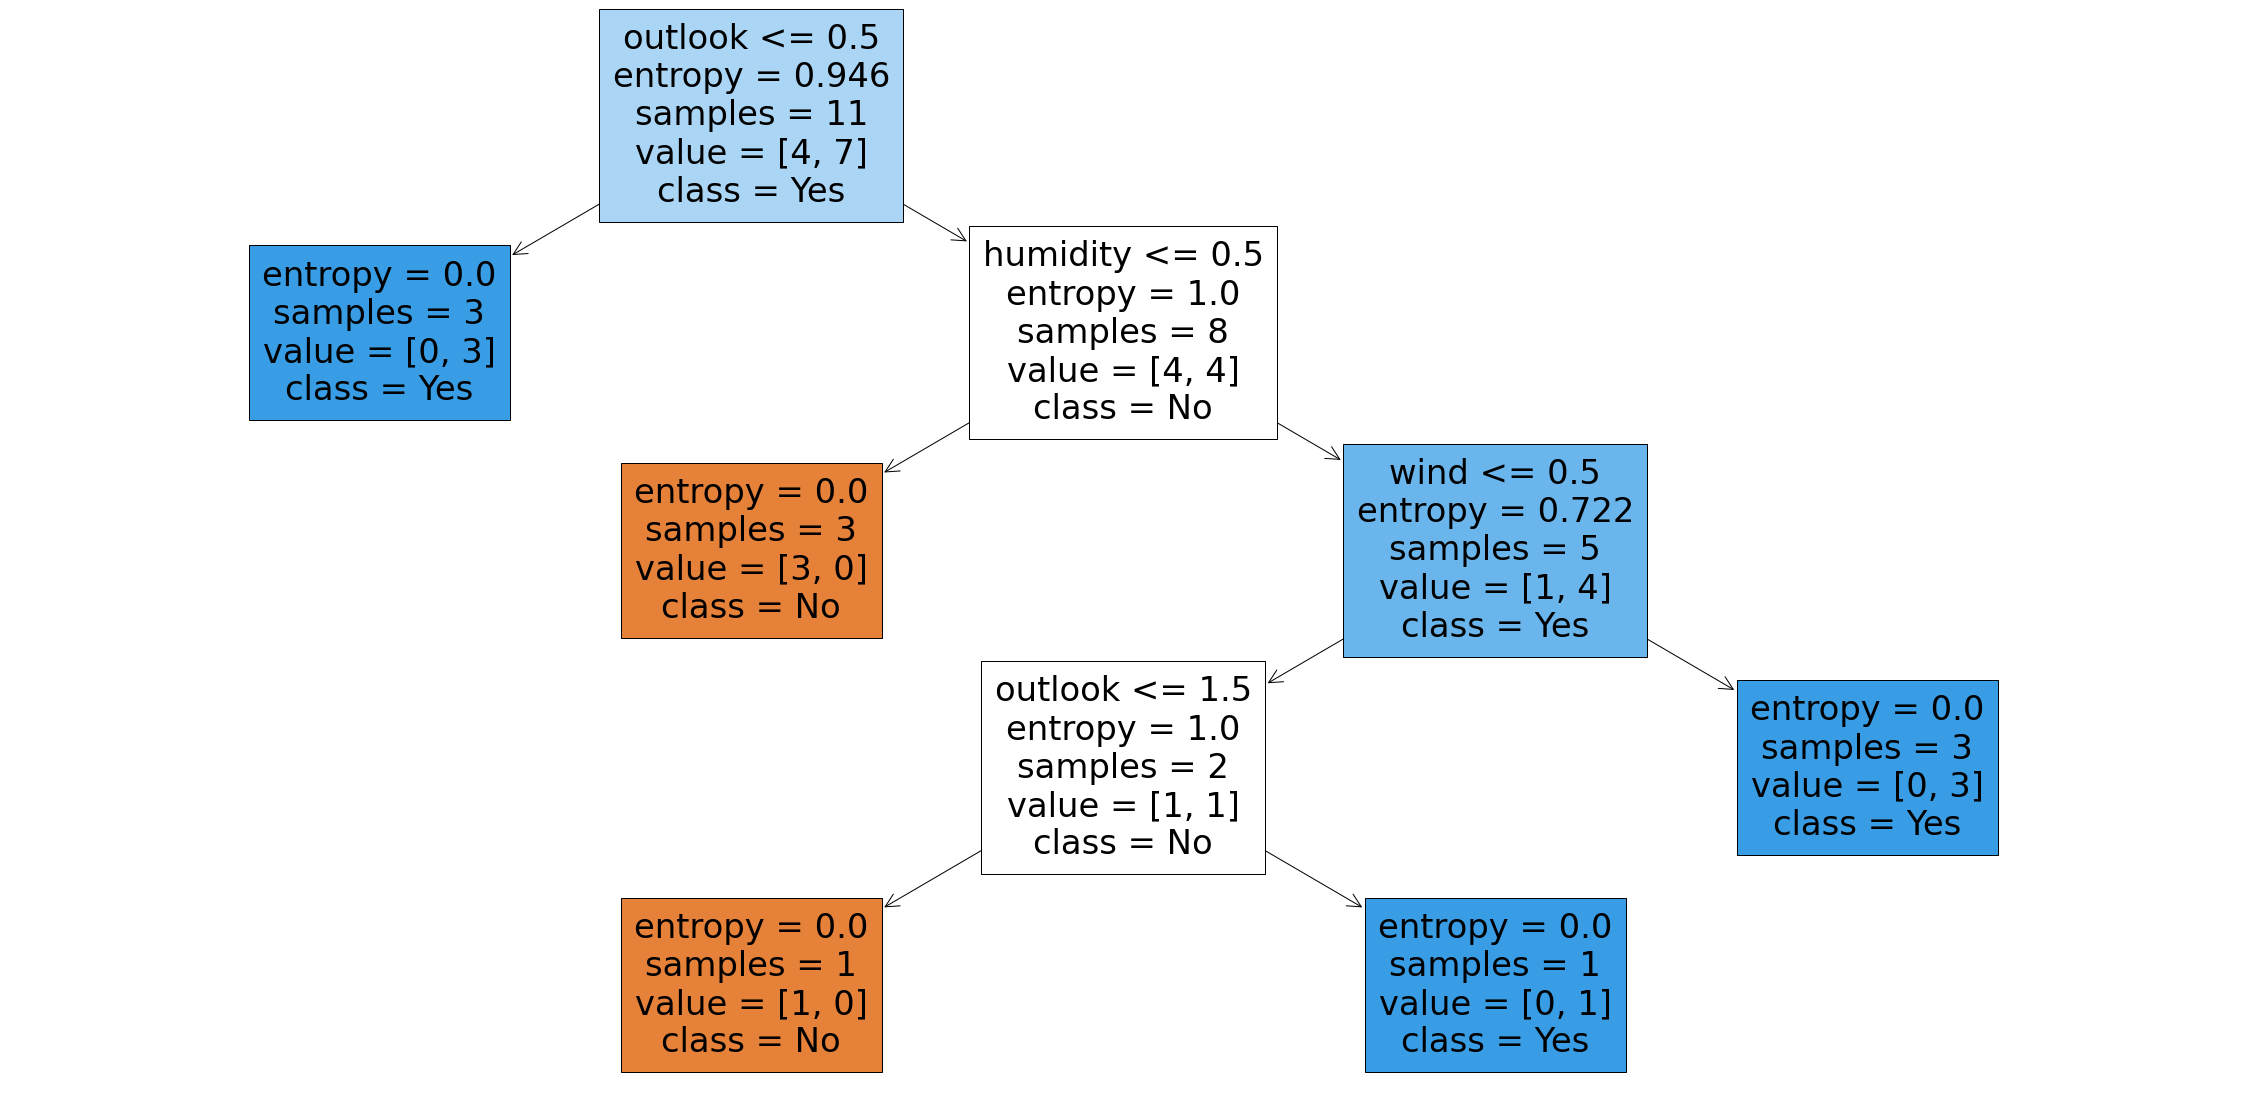

In [89]:
fig = plt.figure(figsize=(40,20))
_ = tree.plot_tree(clf_t,feature_names=dttennis.columns[:-1], class_names=['No','Yes'], filled=True)

In [90]:
fig.savefig("../img/tennis_dtc.png")

### DTC - Analisis Prediksi

In [91]:
printSummary('DTC',c_dtc_acc, c_dtc_f1, t_dtc_acc, t_dtc_f1)

Cancer Dataset:
Accuracy   : 0.9385964912280702
F1 Score   : 0.953020134228188
Tennis Dataset
Accuracy   : 0.6666666666666666
F1 Score   : 0.6666666666666666


Dataset kanker:
- Dataset kanker memiliki akurasi yang cukup tinggi dengan skor akurasi >0.9 yang artinya memiliki akurasi mendekati 90%.
- Dataset kanker memiliki nilai F1 yang cukup tinggi dengan skor akurasi >0.9 yang artinya data cenderung masih seimbang sehingga false negative ataupun ataupun false positive bisa dihindari dengan menggunakan dataset saat ini untuk training.  

Dataset tennis:
- Dataset tennis memiliki akurasi yang cukup rendah dengan skor akurasi ~0.66. Hal ini juga bisa disebabkan karena sedikitnya dataset yang dimiliki sehingga kesalahan kecil akan sangat berdampak pada akurasi.
- Dataset tennis memiliki nilai F1 yang cukup rendah juga karena jumlah data pada dataset yang relatif sedikit sehingga perbedaan 1 record akan berpengaruh besar terhadap *outcome* dari hasil training
- Penggunaan *Decision Tree Classifier* kurang cocok untuk memprediksi dataset tenis karena akan menganggap label sebagai sebuah nilai parameter yang kontinu

## ID3 Estimator

ID3 Algorithm - Iterative Dichotomiser 3
> Algoritma klasitikasi yang menggunakan pendekatan *greedy algorithm* untuk membentuk *decision tree* dengan mencari atribut yang memiliki *information gain* terbesar (atau entropi terkecil)

Tahapan dalam algoritma ID3:
1. Kalkulasi entropi dari dataset
2. Untuk setiap atribut/*feature*:
    1. Hitung entropi dari semua nilai kategorikalnya
    2. Hitung *information gain* dari featurenya
3. Cari *feature* dengan *information gain* terbesar
4. Ulangi hingga habis dan terbentuk decision tree yang diinginkan

### ID3 - Breast Cancer Dataset

In [92]:
estimator = Id3Estimator()
estimator = estimator.fit(x_ctrain, y_ctrain)
y_cpred = estimator.predict(x_ctest)
c_id3_acc = accuracy_score(y_ctest, y_cpred)
c_id3_f1 = f1_score(y_ctest, y_cpred)
printScore(c_id3_acc, c_id3_f1)

Accuracy   : 0.9385964912280702
F1 Score   : 0.953020134228188


Berikut di bawah ini adalah ilustrasi decision tree yang dihasilkan dari pembelajaran mesin IM3 menggunakan library graphviz.

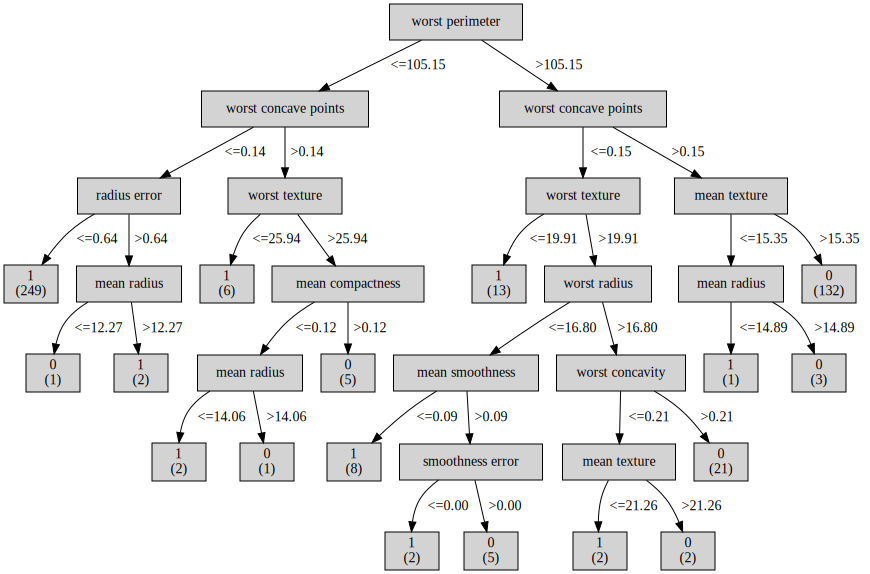

In [93]:
tree = export_graphviz(estimator.tree_, '../graph/c_id3.dot', cancer.feature_names)
graphviz.Source.from_file('../graph/c_id3.dot')

### ID3 - Tennis Dataset

In [94]:
estimator = Id3Estimator()
estimator = estimator.fit(x_tntrain, y_tntrain)
y_tnpred = estimator.predict(x_tntest)
t_id3_acc = accuracy_score(y_tntest, y_tnpred)
t_id3_f1 = f1_score(y_tntest, y_tnpred)
printScore(t_id3_acc, t_id3_f1)

Accuracy   : 0.6666666666666666
F1 Score   : 0.6666666666666666


Berikut di bawah ini adalah ilustrasi decision tree yang dihasilkan dari pembelajaran mesin IM3 menggunakan library graphviz.

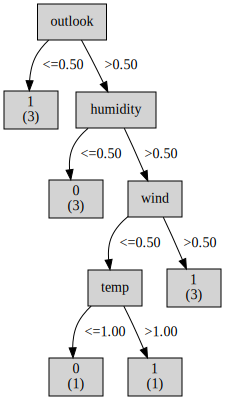

In [95]:
tree = export_graphviz(estimator.tree_, '../graph/t_id3.dot', dttennis.columns[:-1])
graphviz.Source.from_file('../graph/t_id3.dot')

### ID3 - Analisis Prediksi

In [96]:
printSummary('ID3',c_id3_acc, c_id3_f1, t_id3_acc, t_id3_f1)

Cancer Dataset:
Accuracy   : 0.9385964912280702
F1 Score   : 0.953020134228188
Tennis Dataset
Accuracy   : 0.6666666666666666
F1 Score   : 0.6666666666666666


***Tulis Analisis ID3***

In [97]:
recap

,Pembelajaran,Dataset,Tipe,Nilai
0,DTC,Cancer,Accuracy Score,0.938596
1,DTC,Cancer,F1 Score,0.953020
2,DTC,Tennis,Accuracy Score,0.666667
3,DTC,Tennis,F1 Score,0.666667
4,ID3,Cancer,Accuracy Score,0.938596
5,ID3,Cancer,F1 Score,0.953020
6,ID3,Tennis,Accuracy Score,0.666667
7,ID3,Tennis,F1 Score,0.666667


## KMeans

Penjelasan KMeans

In [98]:
# create model
c_kmeans = KMeans(n_clusters=2, random_state=42).fit(x_ctrain)
c_kmeanspredict = c_kmeans.predict(x_ctest)

tn_kmeans = KMeans(n_clusters=2, random_state=42).fit(x_tntrain)
tn_kmeanspredict = tn_kmeans.predict(x_tntest)

In [99]:
# accuracy and f1 score
c_kmeansAccScore = accuracy_score(y_ctest, c_kmeanspredict)
tn_kmeansAccScore = accuracy_score(y_tntest, tn_kmeanspredict)

c_kmeansF1Score = f1_score(y_ctest, c_kmeanspredict, average='weighted')
tn_kmeansF1Score = f1_score(y_tntest, tn_kmeanspredict)

In [101]:
printSummary('KMeans',c_kmeansAccScore, c_kmeansF1Score, tn_kmeansAccScore, tn_kmeansF1Score)

Cancer Dataset:
Accuracy   : 0.19298245614035087
F1 Score   : 0.1191950464396285
Tennis Dataset
Accuracy   : 1.0
F1 Score   : 1.0


## Logistic Regression

Penjelasan Logistic Regression

### Logistic Regression - Breast Cancer Dataset

In [ ]:
logreg = LogisticRegression(max_iter=10000)
logreg = logreg.fit(x_ctrain,y_ctrain)
y_cpred = logreg.predict(x_ctest)
c_logreg_acc = accuracy_score(y_ctest, y_cpred)
c_logreg_f1 = f1_score(y_ctest,y_cpred)

In [ ]:
printScore(c_logreg_acc, c_logreg_f1)

Accuracy   : 0.9473684210526315
F1 Score   : 0.9594594594594595


### Logistic Regression - Tennis Dataset

In [ ]:
logreg = LogisticRegression(max_iter=10000)
logreg = logreg.fit(x_tntrain,y_tntrain)
y_tnpred = logreg.predict(x_tntest)
t_logreg_acc = accuracy_score(y_tntest, y_tnpred)
t_logreg_f1 = f1_score(y_tntest,y_tnpred)

In [ ]:
printScore(t_logreg_acc, t_logreg_f1)

Accuracy   : 0.6666666666666666
F1 Score   : 0.8


### Logistic Regression - Analisis Prediksi

In [102]:
printSummary('Logistc Regression',c_logreg_acc, c_logreg_f1, t_logreg_acc, t_logreg_f1)

NameError: name 'c_logreg_acc' is not defined

## Neural Network

Penjelasan Neural Network

In [ ]:
# create model
clf = MLPClassifier(random_state=1, max_iter=2000)

c_neural = clf.fit(x_ctrain, y_ctrain)
c_neuralpredict = c_neural.predict(x_ctest)

tn_neural = clf.fit(x_tntrain, y_tntrain)
tn_neuralpredict = tn_neural.predict(x_tntest)

In [ ]:
# accuracy and f1 score
c_neuralAccScore = accuracy_score(y_ctest, c_neuralpredict)
tn_neuralAccScore = accuracy_score(y_tntest, tn_neuralpredict)

c_neuralF1Score = f1_score(y_ctest, c_neuralpredict)
tn_neuralF1Score = f1_score(y_tntest, tn_neuralpredict)

In [ ]:
printSummary('Neural Network', c_neuralAccScore, c_neuralF1Score, tn_neuralAccScore, tn_neuralF1Score)

Cancer Dataset:
Accuracy   : 0.9473684210526315
F1 Score   : 0.9594594594594595
Tennis Dataset
Accuracy   : 1.0
F1 Score   : 1.0


## SVM

Penjelasan SVM

In [ ]:
# create model
svc = SVC(C=1, kernel='linear')

c_svc = svc.fit(x_ctrain, y_ctrain)
c_svcpredict = c_svc.predict(x_ctest)

tn_svc = svc.fit(x_tntrain, y_tntrain)
tn_svcpredict = tn_svc.predict(x_tntest)

In [ ]:
# accuracy and f1 score
c_svcAccScore = accuracy_score(y_ctest, c_svcpredict)
tn_scvAccScore = accuracy_score(y_tntest, tn_svcpredict)

c_svcF1Score = f1_score(y_ctest, c_svcpredict)
tn_svcF1Score = f1_score(y_tntest, tn_svcpredict)

In [ ]:
printSummary('SVM',c_svcAccScore, c_svcF1Score, tn_scvAccScore, tn_svcF1Score)

Cancer Dataset:
Accuracy   : 0.956140350877193
F1 Score   : 0.9664429530201343
Tennis Dataset
Accuracy   : 0.6666666666666666
F1 Score   : 0.8


---

# Kesimpulan

lorem ipsum